In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [38]:
from speedml import Speedml
sml = Speedml('input/train.csv', 
              'input/test.csv', 
              target = 'SalePrice',
              uid = 'Id')
sml.shape()

'train (1460, 80) | test (1459, 79)'

In [39]:
sml.configure('overfit_threshold',  sml.np.sqrt(sml.train.shape[0]) / sml.train.shape[0])
sml.configure('outpath',  "/")
sml.configure('high_cardinality',  30)

{'high_cardinality': 10,
 'outlier_threshold': 3,
 'outpath': 'output/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

{'high_cardinality': 10,
 'outlier_threshold': 3,
 'outpath': '/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

{'high_cardinality': 30,
 'outlier_threshold': 3,
 'outpath': '/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

In [40]:
eda_result_df = sml.eda()
eda_result_df

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, BsmtFinSF2, LowQualFinSF, BsmtHalfBa...",Positive skew (> 3). Use feature.outliers(upper).
Shape,"train (1460, 80) | test (1459, 79)",
Numerical Ratio,46%,Aim for 100% numerical.
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, OverallQual, OverallCond, LowQual...",Use plot.ordinal.
Text Categorical,"[Neighborhood, Exterior1st, Condition2, Functi...",Use feature.labels or feature.mapping.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [41]:
print(type(sml.train))
sml.train.head()

<class 'pandas.core.frame.DataFrame'>


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Deal with Outliers 

 Rules of thunmbs here:
 
* Check the relationship b.t. the target (SalePrice) the outlier feature from the eda result
* For a specific feature, if there are extreme values along that feature (far different from the most data on that feature axis), we can check if it could potentially provide information gain. If yes, keep it; otherwise drop it.
* Information gain here: not entropy kind of stuff, but very simple check: How those seemingly outliers correlates to the target feature (SalePrice) ? Or can they help to narrow down or restrain the SalePrice's range ? 

>show the outlier columns, types, and r value w.r.t the SalePrice

In [42]:
from scipy.stats import pearsonr 

In [43]:
outliers_col = eda_result_df['Results'][1]
before_ol_remove_df = pd.DataFrame ({
            'col name': outliers_col, 
            'type': [sml.train[col].dtype for col in outliers_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in outliers_col]
        })
before_ol_remove_df

,col name,r-val,type
0,LotArea,0.263843,int64
1,BsmtFinSF2,-0.011378,int64
2,LowQualFinSF,-0.025606,int64
3,BsmtHalfBath,-0.016844,int64
4,KitchenAbvGr,-0.135907,int64
5,EnclosedPorch,-0.128578,int64
6,3SsnPorch,0.044584,int64
7,ScreenPorch,0.111447,int64
8,PoolArea,0.092404,int64
9,MiscVal,-0.021190,int64


In [44]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

### check **LotArea**

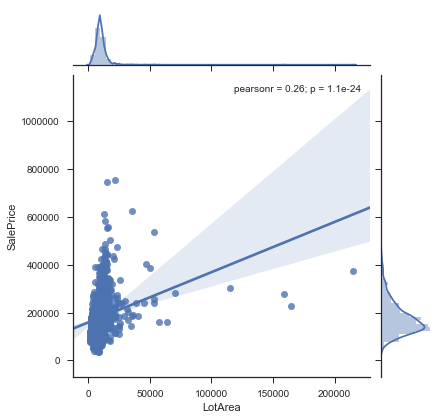

In [45]:
sns.jointplot(x='LotArea', y="SalePrice", data=sml.train, kind="reg") 

if we look into for LotArea's seemingly outliers, say where LotArea > 52000

check outlier precentage = 0.685 %


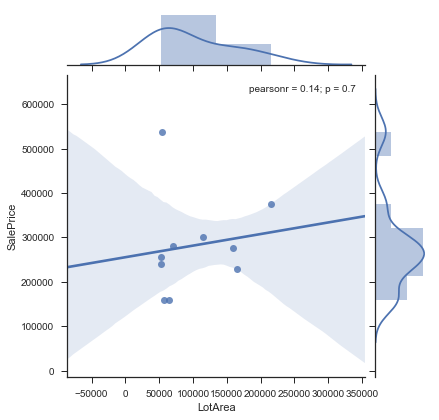

In [46]:
temp_df = sml.train[sml.train['LotArea'] > 52000]
print('check outlier precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LotArea', y="SalePrice", data=temp_df, kind="reg")


LotArea seems to be highly relative to the SalePrice, (r=.26)
and those seemingly outliers are also relative to the SalePrice. (r = .14),

So if we treat those as outliers, we might somehow hide the data from the training model and hurt the predictions.

In the LotArea feature, different values in different range just show different linear relationship (from the perspective of linear reg.) to the SalePrice values. Having far away values does not always make it true outlier.

conclusion: ** keep the LotArea**

### check **BsmtFinSF2**

since *BsmtFinSF2: Type 2 finished square feet*
> 0 basically just mean no information. So we should analyze without 0 here to have clear picture of how it affects the SalePrice

check precentage = 11.438 %


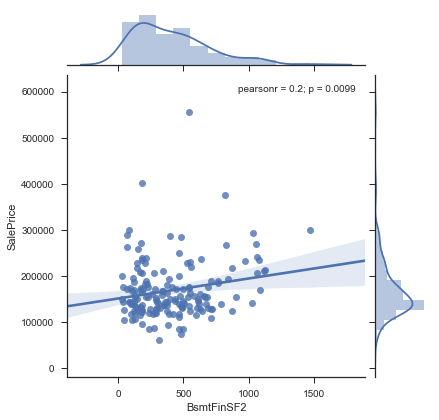

In [47]:
temp_df = sml.train[sml.train['BsmtFinSF2'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtFinSF2', y="SalePrice", data=temp_df, kind="reg") 

BsmtFinSF2 without 0 now seems to be highly related to the SalePrice, (r=.2)

conclusion: ** keep the BsmtFinSF2**

### check **LowQualFinSF**

> same reason as BstmFinSF2, we have to focus on LowQualFinSF > 0

check precentage = 1.781 %


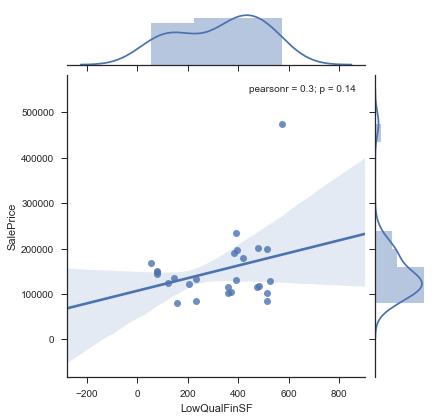

In [48]:
temp_df = sml.train[sml.train['LowQualFinSF'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LowQualFinSF', y="SalePrice", data=temp_df, kind="reg") 

LowQualFinSF without 0 now seems to be highly related to the SalePrice, (r=.3)
There is one outlier, which compose 1/1460 ~= 0.0685 % of the data => upper = 99.93

conclusion: ** keep the LowQualFinSF but remove one outlier (~upper = 99.93)**

### check **BsmtHalfBath**

check precentage = 100.000 %


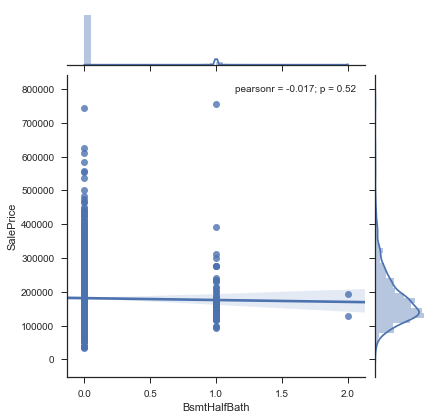

In [49]:
temp_df = sml.train[sml.train['BsmtHalfBath'] > -1]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtHalfBath', y="SalePrice", data=temp_df, kind="reg") 

BsmtHalfBath = 2 seems to restrain the range of SalePrice, which could be still informative. 

conclusion: ** keep the BsmtHalfBath**

### check **KitchenAbvGr**

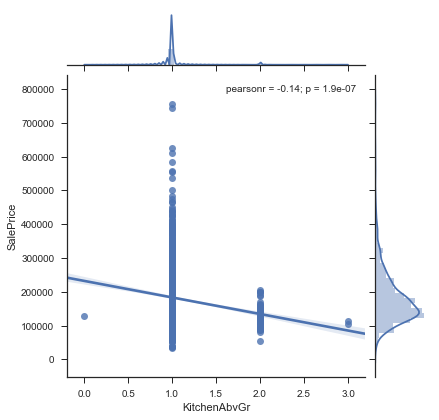

In [50]:
sns.jointplot(x='KitchenAbvGr', y="SalePrice", data=sml.train, kind="reg") 

same reason as BsmtHalfBath

conclusion: ** keep the KitchenAbvGr**

### check **EnclosedPorch**

> same reason as BstmFinSF2, we have to focus on EnclosedPorch > 0

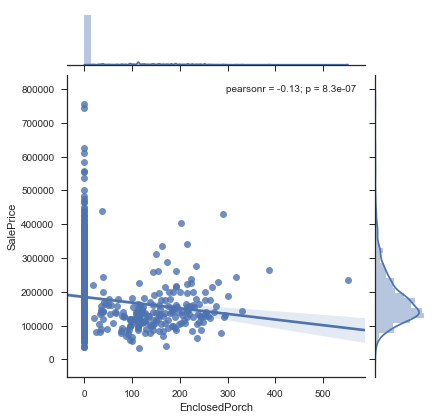

In [51]:
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=sml.train, kind="reg") 

check precentage = 14.247 %


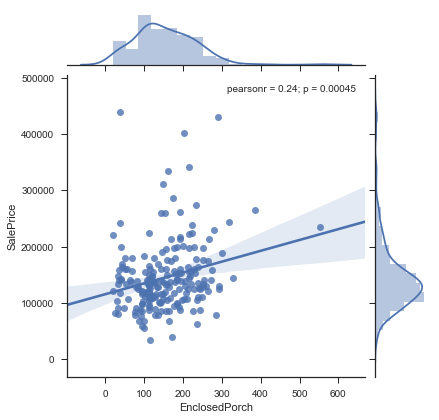

In [52]:
temp_df = sml.train[sml.train['EnclosedPorch'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=temp_df, kind="reg") 

Wow, the seemingly outlier almost follows the linear relationsip from the above.

conclusion: ** keep the EnclosedPorch**

### check **3SsnPorch**

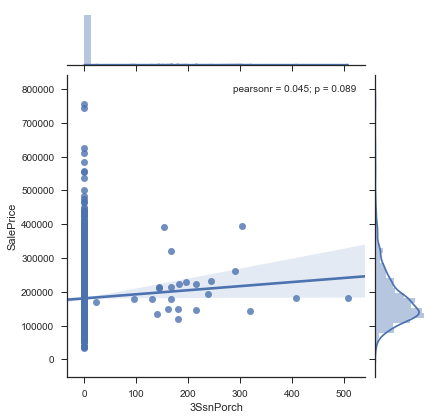

In [53]:
sns.jointplot(x='3SsnPorch', y="SalePrice", data=sml.train, kind="reg") 

focus on 3SsnPorch > 200

check precentage = 0.616 %


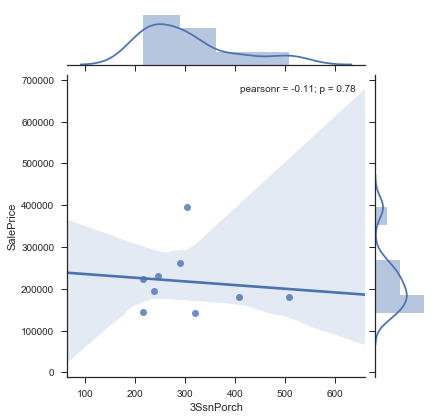

In [54]:
temp_df = sml.train[sml.train['3SsnPorch'] > 200]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='3SsnPorch', y="SalePrice", data=temp_df, kind="reg") 

it seems that having too much 3SsnPorch area have a slightly negative effect on the SalePrice, hmm...

The outlier almost follows the linear relationsip from the above.

conclusion: ** keep the 3SsnPorch**

### check **ScreenPorch**

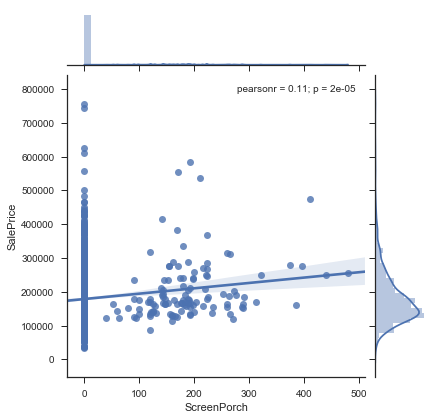

In [55]:
sns.jointplot(x='ScreenPorch', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the positive relationship

conclusion: ** keep the 3SsnPorch**

### check **PoolArea**

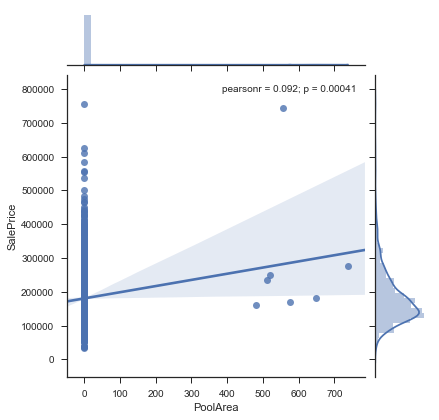

In [56]:
sns.jointplot(x='PoolArea', y="SalePrice", data=sml.train, kind="reg") 

focus on PoolArea > 400

check precentage = 0.479 %


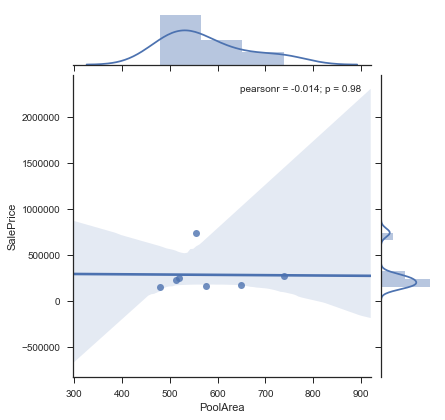

In [57]:
temp_df = sml.train[sml.train['PoolArea'] > 400]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='PoolArea', y="SalePrice", data=temp_df, kind="reg") 

the seemingly outliers seems to restrain the SalePrice to around 25000, if there are pools!

conclusion: ** keep the PoolArea**

### check **MiscVal**

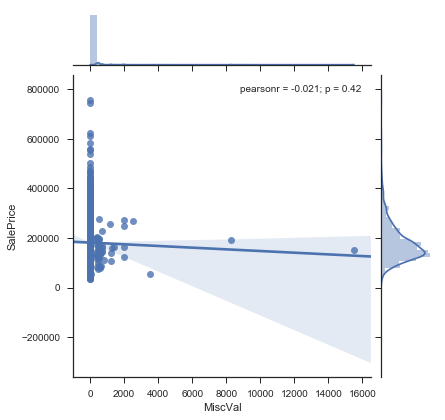

In [58]:
sns.jointplot(x='MiscVal', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the slightly negative relationship

conclusion: ** keep the MisVal**

Observe from the distribution above, we can assume whether there might be outliers or not

* LotArea: Lot size in square feet
* BsmtFinSF2: Type 2 finished square feet 
* LowQualFinSF: Low quality finished square feet (all floors)  
* BsmtHalfBath: Basement half bathrooms 
* KitchenAbvGr: Total rooms above grade (does not include bathrooms) 
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* MiscVal: $Value of miscellaneous feature

this function removes the outliers (upper) and draw the continuous plot before and after the removal


In [59]:
def plot_outliers(outlier_dict):
    for col in outlier_dict:
        sml.plot.continuous(col)
        sml.feature.outliers(col, upper=outlier_dict[col])
        sml.plot.continuous(col)

"\noutlier_dict = {\n    'LotArea'       :  99.5,\n    'BsmtFinSF2'    :  99 ,   \n    'LowQualFinSF'  :  99.93,\n    'BsmtHalfBath'  :  99,\n    'KitchenAbvGr'  :  99,\n    'EnclosedPorch' :  99,\n    '3SsnPorch'     :  99,\n    'ScreenPorch'   :  99,\n    'PoolArea'      :  99,\n    'MiscVal'       :  99,\n}\n"

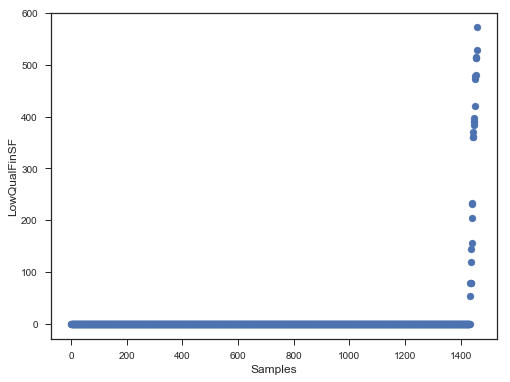

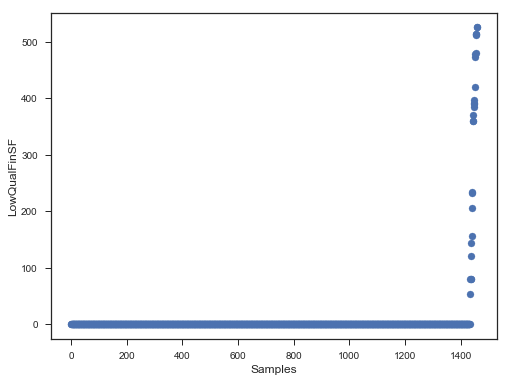

In [60]:

outlier_dict = {
    'LowQualFinSF'  :  99.92,
}
'''
outlier_dict = {
    'LotArea'       :  99.5,
    'BsmtFinSF2'    :  99 ,   
    'LowQualFinSF'  :  99.93,
    'BsmtHalfBath'  :  99,
    'KitchenAbvGr'  :  99,
    'EnclosedPorch' :  99,
    '3SsnPorch'     :  99,
    'ScreenPorch'   :  99,
    'PoolArea'      :  99,
    'MiscVal'       :  99,
}
'''

plot_outliers(outlier_dict)


# Feature Engineering

In [61]:
sml.feature.impute()
eda_result_df = sml.eda()
eda_result_df

'Imputed 6965 empty values to 0.'

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, BsmtFinSF2, LowQualFinSF, BsmtHalfBa...",Positive skew (> 3). Use feature.outliers(upper).
Shape,"train (1460, 80) | test (1459, 79)",
Numerical Ratio,46%,Aim for 100% numerical.
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, OverallQual, OverallCond, LowQual...",Use plot.ordinal.
Text Categorical,"[Neighborhood, Exterior1st, Condition2, Functi...",Use feature.labels or feature.mapping.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [62]:
high_card_num_col = eda_result_df['Results'][4]
df = pd.DataFrame ({
            'col name': high_card_num_col, 
            'type': [sml.train[col].dtype for col in high_card_num_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in high_card_num_col]
        })
df

,col name,r-val,type
0,LotFrontage,0.334544,float64
1,LotArea,0.263843,int64
2,YearBuilt,0.522897,int64
3,YearRemodAdd,0.507101,int64
4,MasVnrArea,0.472614,float64
5,BsmtFinSF1,0.386420,float64
6,BsmtFinSF2,-0.011378,float64
7,BsmtUnfSF,0.214479,float64
8,TotalBsmtSF,0.613581,float64
9,1stFlrSF,0.605852,int64


## High cardinality num 

> create density features for all numerical cols with high card. num.

In [63]:
'''
for col in high_card_num_col:
    if col != 'SalePrice':
        sml.feature.density(col)
'''    

"\nfor col in high_card_num_col:\n    if col != 'SalePrice':\n        sml.feature.density(col)\n"

In [64]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 25

## Category text 

In [65]:
text_cat_col = eda_result_df['Results'][6]
print(len(text_cat_col))
sml.train[text_cat_col].head(25)

43


,Neighborhood,Exterior1st,Condition2,Functional,PoolQC,Condition1,MasVnrType,BsmtCond,FireplaceQu,Utilities,HouseStyle,KitchenQual,HeatingQC,Heating,CentralAir,LotShape,LotConfig,GarageQual,Fence,SaleType,GarageCond,MSZoning,LandContour,RoofMatl,ExterQual,PavedDrive,Street,BsmtExposure,MiscFeature,BsmtQual,Electrical,Alley,BsmtFinType1,BldgType,Exterior2nd,Foundation,GarageType,GarageFinish,RoofStyle,LandSlope,BsmtFinType2,SaleCondition,ExterCond
0,CollgCr,VinylSd,Norm,Typ,Gd,Norm,BrkFace,TA,Gd,AllPub,2Story,Gd,Ex,GasA,Y,Reg,Inside,TA,MnPrv,WD,TA,RL,Lvl,CompShg,Gd,Y,Pave,No,Shed,Gd,SBrkr,Grvl,GLQ,1Fam,VinylSd,PConc,Attchd,RFn,Gable,Gtl,Unf,Normal,TA
1,Veenker,MetalSd,Norm,Typ,Gd,Feedr,None,TA,TA,AllPub,1Story,TA,Ex,GasA,Y,Reg,FR2,TA,MnPrv,WD,TA,RL,Lvl,CompShg,TA,Y,Pave,Gd,Shed,Gd,SBrkr,Grvl,ALQ,1Fam,MetalSd,CBlock,Attchd,RFn,Gable,Gtl,Unf,Normal,TA
2,CollgCr,VinylSd,Norm,Typ,Gd,Norm,BrkFace,TA,TA,AllPub,2Story,Gd,Ex,GasA,Y,IR1,Inside,TA,MnPrv,WD,TA,RL,Lvl,CompShg,Gd,Y,Pave,Mn,Shed,Gd,SBrkr,Grvl,GLQ,1Fam,VinylSd,PConc,Attchd,RFn,Gable,Gtl,Unf,Normal,TA
3,Crawfor,Wd Sdng,Norm,Typ,Gd,Norm,None,Gd,Gd,AllPub,2Story,Gd,Gd,GasA,Y,IR1,Corner,TA,MnPrv,WD,TA,RL,Lvl,CompShg,TA,Y,Pave,No,Shed,TA,SBrkr,Grvl,ALQ,1Fam,Wd Shng,BrkTil,Detchd,Unf,Gable,Gtl,Unf,Abnorml,TA
4,NoRidge,VinylSd,Norm,Typ,Gd,Norm,BrkFace,TA,TA,AllPub,2Story,Gd,Ex,GasA,Y,IR1,FR2,TA,MnPrv,WD,TA,RL,Lvl,CompShg,Gd,Y,Pave,Av,Shed,Gd,SBrkr,Grvl,GLQ,1Fam,VinylSd,PConc,Attchd,RFn,Gable,Gtl,Unf,Normal,TA
5,Mitchel,VinylSd,Norm,Typ,Gd,Norm,None,TA,Gd,AllPub,1.5Fin,TA,Ex,GasA,Y,IR1,Inside,TA,MnPrv,WD,TA,RL,Lvl,CompShg,TA,Y,Pave,No,Shed,Gd,SBrkr,Grvl,GLQ,1Fam,VinylSd,Wood,Attchd,Unf,Gable,Gtl,Unf,Normal,TA
6,Somerst,VinylSd,Norm,Typ,Gd,Norm,Stone,TA,Gd,AllPub,1Story,Gd,Ex,GasA,Y,Reg,Inside,TA,MnPrv,WD,TA,RL,Lvl,CompShg,Gd,Y,Pave,Av,Shed,Ex,SBrkr,Grvl,GLQ,1Fam,VinylSd,PConc,Attchd,RFn,Gable,Gtl,Unf,Normal,TA
7,NWAmes,HdBoard,Norm,Typ,Gd,PosN,Stone,TA,TA,AllPub,2Story,TA,Ex,GasA,Y,IR1,Corner,TA,MnPrv,WD,TA,RL,Lvl,CompShg,TA,Y,Pave,Mn,Shed,Gd,SBrkr,Grvl,ALQ,1Fam,HdBoard,CBlock,Attchd,RFn,Gable,Gtl,BLQ,Normal,TA
8,OldTown,BrkFace,Norm,Min1,Gd,Artery,None,TA,TA,AllPub,1.5Fin,TA,Gd,GasA,Y,Reg,Inside,Fa,MnPrv,WD,TA,RM,Lvl,CompShg,TA,Y,Pave,No,Shed,TA,FuseF,Grvl,Unf,1Fam,Wd Shng,BrkTil,Detchd,Unf,Gable,Gtl,Unf,Abnorml,TA
9,BrkSide,MetalSd,Artery,Typ,Gd,Artery,None,TA,TA,AllPub,1.5Unf,TA,Ex,GasA,Y,Reg,Corner,Gd,MnPrv,WD,TA,RL,Lvl,CompShg,TA,Y,Pave,No,Shed,TA,SBrkr,Grvl,GLQ,2fmCon,MetalSd,BrkTil,Attchd,RFn,Gable,Gtl,Unf,Normal,TA


> convert text with category type into numerical labels

In [66]:
for col in text_cat_col:
    sml.feature.labels([col])

In [67]:
sml.eda()

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, Alley, Utilities, LandSlope, Conditi...",Positive skew (> 3). Use feature.outliers(upper).
Outliers Lower,"[Street, LandContour, BsmtCond, BsmtFinType2, ...",Negative skew (< -3). Use feature.outliers(low...
Shape,"train (1460, 80) | test (1459, 79)",
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, MSZoning, Street, Alley, LotShape...",Use plot.ordinal.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [68]:
sml.train.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,0,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,0.0,150.0,856.0,1,0,1,4,856,854,0.0,1710,1.0,0.0,2,1,3,1,2,8,6,0,2,1,2003.0,1,2.0,548.0,4,4,2,0,61,0,0,0,0,2,2,2,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,0,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,0.0,284.0,1262.0,1,0,1,4,1262,0,0.0,1262,0.0,1.0,2,0,3,1,3,6,6,1,4,1,1976.0,1,2.0,460.0,4,4,2,298,0,0,0,0,0,2,2,2,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,0.0,434.0,920.0,1,0,1,4,920,866,0.0,1786,1.0,0.0,2,1,3,1,2,6,6,1,4,1,2001.0,1,2.0,608.0,4,4,2,0,42,0,0,0,0,2,2,2,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,0.0,540.0,756.0,1,2,1,4,961,756,0.0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3.0,642.0,4,4,2,0,35,272,0,0,0,2,2,2,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,0.0,490.0,1145.0,1,0,1,4,1145,1053,0.0,2198,1.0,0.0,2,1,4,1,2,9,6,1,4,1,2000.0,1,3.0,836.0,4,4,2,192,84,0,0,0,0,2,2,2,0,12,2008,8,4,250000
5,50,3,85.0,14115,1,0,0,3,0,4,0,11,2,2,0,0,5,5,1993,1995,1,1,12,13,2,0.0,3,4,5,2,3,3,2,732.0,5,0.0,64.0,796.0,1,0,1,4,796,566,0.0,1362,1.0,0.0,1,1,1,1,3,5,6,0,2,1,1993.0,2,2.0,480.0,4,4,2,40,30,0,320,0,0,2,2,2,700,10,2009,8,4,143000
6,20,3,75.0,10084,1,0,3,3,0,4,0,21,2,2,0,2,8,5,2004,2005,1,1,12,13,3,186.0,2,4,2,0,3,0,2,1369.0,5,0.0,317.0,1686.0,1,0,1,4,1694,0,0.0,1694,1.0,0.0,2,0,3,1,2,7,6,1,2,1,2004.0,1,2.0,636.0,4,4,2,255,57,0,0,0,0,2,2,2,0,8,2007,8,4,307000
7,60,3,68.0,10382,1,0,0,3,0,0,0,14,4,2,0,5,7,6,1973,1973,1,1,6,6,3,240.0,3,4,1,2,3,2,0,859.0,1,32.0,216.0,1107.0,1,0,1,4,1107,983,0.0,2090,1.0,0.0,2,1,3,1,3,7,6,2,4,1,1973.0,1,2.0,484.0,4,4,2,235,204,228,0,0,0,2,2,2,350,11,2009,8,4,200000
8,50,4,51.0,6120,1,0,3,3,0,4,0,17,0,2,0,0,7,5,1931,1950,1,1,3,15,2,0.0,3,4,0,3,3,3,5,0.0,5,0.0,952.0,952.0,1,2,1,1,1022,752,0.0,1774,0.0,0.0,2,0,2,2,3,8,2,2,4,5,1931.0,2,2.0,468.0,1,4,2,90,0,205,0,0,0,2,2,2,0,4,2008,8,0,129900
9,190,3,50.0,7420,1,0,3,3,0,0,0,3,0,0,1,1,5,6,1939,1950,1,1,8,8,2,0.0,3,4,0,3,3,3,2,851.0,5,0.0,140.0,991.0,1,0,1,4,1077,0,0.0,1077,1.0,0.0,1,0,2,2,3,5,6,2,4,1,1939.0,1,1.0,205.0,2,4,2,0,4,0,0,0,0,2,2,2,0,1,2008,8,4,118000


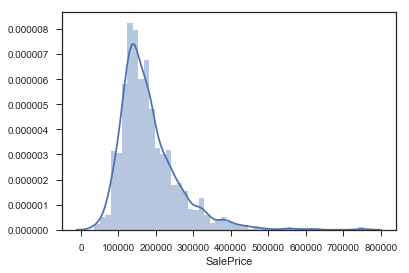

In [69]:
sns.distplot(sml.train['SalePrice'])

# Use DNN to train with multiple features

* Use Adam
* Xavier initialization
* Drop

In [70]:
train = sml.train
test = sml.test

print("features:" , len(test.columns))

features: 79


In [71]:
train_x = train[[col for col in train.columns if col != 'SalePrice']]
train_y = np.log(train['SalePrice']).reshape(train_x.shape[0], 1)

train_x = train_x.T
train_y = train_y.T
test_x = test.T

print(train_x.shape, train_y.shape, test_x.shape)

(79, 1460) (1, 1460) (79, 1459)


C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [85]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name='Y')
    phase = tf.placeholder(tf.bool, name='phase')
    
    return X, Y, phase

def initialize_parameters( n_feature, n_output,
    layer_count = 3, hidden_neuron = [25, 12]):
       
    W = []
    b = []

    for i in range(layer_count):
        weight_str = 'W'+str(i+1)
        bias_str = 'b'+str(i+1)

        if i == 0:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], n_feature], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
        elif i == layer_count - 1:
            weight = tf.get_variable(weight_str, [n_output, hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [n_output, 1], initializer = tf.zeros_initializer())
        else:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
            
        W.append(weight)
        b.append(bias)

    parameters = {
        'W': W,
        'b': b
    }

    return parameters

def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.9)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed
    
def forward_propagation(X, parameters, is_training):

    W = parameters['W']
    b = parameters['b']
    
    for i in range(len(W)):
        weight = W[i]
        bias = b[i]
        scope = 'layer' + str(i+1)
        with tf.variable_scope(scope):
            if i == 0:
                output = tf.matmul(weight, X) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)
            elif i == len(W)-1:
                output = tf.matmul(weight, activation) + bias
            else:
                output = tf.matmul(weight, activation) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)

    return output

def compute_cost(parameters, output, Y):

    with tf.name_scope('loss'):
        loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))
        for w in parameters['W']:
            loss = loss + 0.01*tf.nn.l2_loss(w)
        
        return loss
        
    raise ValueError('Cannot enter scope \"loss \"')
    
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[:, permutation]
    shuffled_Y = Y[:,permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X.iloc[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X.iloc[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    
def model(X_train, Y_train, 
        learning_rate = 0.01,
        num_epochs = 1500, 
        minibatch_size = 32, 
        print_cost = True, 
        layer_count = 3, 
        hidden_neuron = [25, 12]):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, phase = create_placeholders(n_x, n_y)

    # Initialize parameters
    # n_feature, n_output,
    # layer_count = 3, hidder_neuron = [25, 12]
    parameters = initialize_parameters(n_x, n_y, layer_count = layer_count, hidden_neuron = hidden_neuron)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    output = forward_propagation(X, parameters, phase)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(parameters, output, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    global_step = tf.Variable(0, trainable=False)
    online_learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                           10000, 0.95, staircase=True)
    
    # Note: when training, the moving_mean and moving_variance need to be updated. 
    # By default the update ops are placed in tf.GraphKeys.UPDATE_OPS, 
    # so they need to be added as a dependency to the train_op
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):                                       
        optimizer = tf.train.AdamOptimizer(learning_rate = online_learning_rate).minimize(cost, global_step=global_step)
      
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # show graph
    show_graph(tf.get_default_graph().as_graph_def())
    
    # Calculate the correct predictions
    rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))

    # Calculate accuracy on the test set
    rmse = tf.cast(rmse, "float")
    
    # Start the session to compute the tensorflow graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, phase:True})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("Training set rmse:", rmse.eval({X: X_train, Y: Y_train, phase:False}))
                
            if print_cost == True and epoch % 5 == 0 and epoch > 300:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        #print ("Test RMSE:", rmse.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [ ]:
# model(X_train, Y_train, learning_rate = 0.0001,
# num_epochs = 1500, minibatch_size = 32, print_cost = True, layer_count = 3, hidder_neuron = [25, 12])

parameters = model(train_x, train_y, 
                   learning_rate=0.01, 
                   num_epochs=500000, 
                   minibatch_size = 64,
                   layer_count = 10, 
                   hidden_neuron = [100, 200, 400, 200, 100, 100, 100, 50, 25])


Cost after epoch 0: 15.581023
Training set rmse: 8.03113
Cost after epoch 100: 0.362443
Training set rmse: 0.309497
Cost after epoch 200: 0.259927
Training set rmse: 0.187302
Cost after epoch 300: 0.266744
Training set rmse: 0.454839
Cost after epoch 400: 0.243938
Training set rmse: 0.422719
Cost after epoch 500: 0.217018
Training set rmse: 0.313444
Cost after epoch 600: 0.233884
Training set rmse: 0.630217
Cost after epoch 700: 0.224951
Training set rmse: 0.490691
Cost after epoch 800: 0.215064
Training set rmse: 0.196641
Cost after epoch 900: 0.227630
Training set rmse: 0.539963
Cost after epoch 1000: 0.223551
Training set rmse: 0.649041
Cost after epoch 1100: 0.202237
Training set rmse: 0.351258
Cost after epoch 1200: 0.248956
Training set rmse: 0.395556
Cost after epoch 1300: 0.205581
Training set rmse: 0.258248
Cost after epoch 1400: 0.209903
Training set rmse: 0.181554
Cost after epoch 1500: 0.236416
Training set rmse: 0.847012
Cost after epoch 1600: 0.207980
Training set rmse: 0

Cost after epoch 13700: 0.187974
Training set rmse: 0.301179
Cost after epoch 13800: 0.182765
Training set rmse: 0.511915
Cost after epoch 13900: 0.192873
Training set rmse: 0.307214
Cost after epoch 14000: 0.199304
Training set rmse: 0.293791
Cost after epoch 14100: 0.175153
Training set rmse: 0.176443
Cost after epoch 14200: 0.178946
Training set rmse: 0.288108
Cost after epoch 14300: 0.181770
Training set rmse: 0.491856
Cost after epoch 14400: 0.175355
Training set rmse: 0.27822
Cost after epoch 14500: 0.179874
Training set rmse: 0.169282
Cost after epoch 14600: 0.187307
Training set rmse: 0.154033
Cost after epoch 14700: 0.174684
Training set rmse: 0.329697
Cost after epoch 14800: 0.171289
Training set rmse: 0.293679
Cost after epoch 14900: 0.177424
Training set rmse: 0.41353
Cost after epoch 15000: 0.175953
Training set rmse: 0.391608
Cost after epoch 15100: 0.185996
Training set rmse: 0.159923
Cost after epoch 15200: 0.177947
Training set rmse: 0.170701
Cost after epoch 15300: 0.

Cost after epoch 27200: 0.145213
Training set rmse: 0.304146
Cost after epoch 27300: 0.145941
Training set rmse: 0.449811
Cost after epoch 27400: 0.148209
Training set rmse: 0.244933
Cost after epoch 27500: 0.148516
Training set rmse: 0.151699
Cost after epoch 27600: 0.152271
Training set rmse: 0.471507
Cost after epoch 27700: 0.153720
Training set rmse: 0.149704
Cost after epoch 27800: 0.154440
Training set rmse: 0.575599
Cost after epoch 27900: 0.149476
Training set rmse: 0.209435
Cost after epoch 28000: 0.148681
Training set rmse: 0.241051
Cost after epoch 28100: 0.151137
Training set rmse: 0.479197
Cost after epoch 28200: 0.150831
Training set rmse: 0.172882
Cost after epoch 28300: 0.148568
Training set rmse: 0.32135
Cost after epoch 28400: 0.144540
Training set rmse: 0.187514
Cost after epoch 28500: 0.152191
Training set rmse: 0.452637
Cost after epoch 28600: 0.158269
Training set rmse: 0.188972
Cost after epoch 28700: 0.151353
Training set rmse: 0.209535
Cost after epoch 28800: 0

Cost after epoch 40700: 0.135181
Training set rmse: 0.125209
Cost after epoch 40800: 0.138804
Training set rmse: 0.117697
Cost after epoch 40900: 0.137044
Training set rmse: 0.118161
Cost after epoch 41000: 0.135329
Training set rmse: 0.118895
Cost after epoch 41100: 0.143141
Training set rmse: 0.135482
Cost after epoch 41200: 0.140140
Training set rmse: 0.136863
Cost after epoch 41300: 0.141257
Training set rmse: 0.125816
Cost after epoch 41400: 0.132167
Training set rmse: 0.121907
Cost after epoch 41500: 0.132378
Training set rmse: 0.117203
Cost after epoch 41600: 0.142945
Training set rmse: 0.125694
Cost after epoch 41700: 0.141750
Training set rmse: 0.125329
Cost after epoch 41800: 0.136961
Training set rmse: 0.130058
Cost after epoch 41900: 0.138776
Training set rmse: 0.15128
Cost after epoch 42000: 0.128668
Training set rmse: 0.122416
Cost after epoch 42100: 0.137755
Training set rmse: 0.1343
Cost after epoch 42200: 0.130823
Training set rmse: 0.139298
Cost after epoch 42300: 0.1

Cost after epoch 54200: 0.131828
Training set rmse: 0.12177
Cost after epoch 54300: 0.122633
Training set rmse: 0.110256
Cost after epoch 54400: 0.124956
Training set rmse: 0.104993
Cost after epoch 54500: 0.131479
Training set rmse: 0.113185
Cost after epoch 54600: 0.131236
Training set rmse: 0.11817
Cost after epoch 54700: 0.125020
Training set rmse: 0.106301
Cost after epoch 54800: 0.132882
Training set rmse: 0.112444
Cost after epoch 54900: 0.130007
Training set rmse: 0.130556
Cost after epoch 55000: 0.130287
Training set rmse: 0.107602
Cost after epoch 55100: 0.125864
Training set rmse: 0.104955
Cost after epoch 55200: 0.126800
Training set rmse: 0.108002
Cost after epoch 55300: 0.125256
Training set rmse: 0.105371
Cost after epoch 55400: 0.130047
Training set rmse: 0.126821
Cost after epoch 55500: 0.125828
Training set rmse: 0.107441
Cost after epoch 55600: 0.126596
Training set rmse: 0.109035
Cost after epoch 55700: 0.125944
Training set rmse: 0.105176
Cost after epoch 55800: 0.

In [ ]:
print(parameters)

In [ ]:
import pickle

filename = 'dnn_10_layer.dmp'
pickle.dump(parameters, open(filename,'wb'))
print('Parameters info is dumped into file: ', filename)